# Twitter Analysis - Russia Ukraine Conflict 
---
## Names: Suraj Nair, Christopher Flanagan
---

# Abstract

In this project, we analyze tweets regarding the Russia-Ukraine conflict using various techniques such as TF-IDF Vectorization, Non-negative Matrix Factorization for topic modeling, K-Means Clustering, Sentiment Analysis, and more. 

# Introduction

The Russia-Ukraine conflict has been ongoing for many years and escalated immensely in Februrary 2022 with Russia's invasion of Ukraine. To give a very brief overview of the situation, Russia wishes to take control of Ukraine as part of a complicated history between the nations stemming back to when Ukraine was originally just a part of Russia prior to independence in 1991. This show of force has sparked mass reaction from all around the globe and with this age of technology, people are able to make their voices heard through various social media platforms. For our project, we've decided to dive deep into tweets regarding the Russia-Ukraine conflict.

In [1]:
# Importing all necessary packages

import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from html import unescape
import csv
import gc
import string

import nltk
#nltk.download('wordnet')
from nltk.corpus import stopwords    # remove stopwords
from nltk.stem.porter import PorterStemmer    # stemmer
from nltk.stem.snowball import SnowballStemmer    # stemmer
from nltk.stem import WordNetLemmatizer    # lemmatization
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

import wordcloud
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer    # BOW
from sklearn.feature_extraction.text import TfidfVectorizer    # Tf-idf
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans



import scipy.sparse as sps
from scipy import linalg
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.spatial.distance as scdist

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import seaborn as sns
import text2emotion as te

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chrisflanagan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chrisflanagan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chrisflanagan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Acquiring data
df= pd.read_csv("/Users/chrisflanagan/Desktop/544/project/dataSources/UkraineTwitter1.csv")
df = df.iloc[:7500,:]
df.head()

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,1,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,retweetcount,text,hashtags,language,coordinates,favorite_count,extractedts
0,1141800,1466752038960656385,Curtin2Tiffany,I am just like everyone else. The universe ex...,"Colorado, USA",253,40.0,94.0,2021-12-03 12:52:22.000000,1.497725e+18,2022-02-27 00:07:16,5.0,#UkraineRussiaWar Captured Russian soldiers\n\...,"[{'text': 'UkraineRussiaWar', 'indices': [19, ...",en,NaN,0.0,2022-02-27 00:09:33.084131
1,1141801,1111276809302216710,5ela60,الأب ..الأخ ..الجار ..الحبيب .. السديك,NaN,167,9.0,656.0,2019-03-28 14:40:12.000000,1.497725e+18,2022-02-27 00:07:16,28.0,Like everybody else I am rooting for Ukraine t...,[],en,NaN,0.0,2022-02-27 00:09:33.068011
2,1141802,1364735420236505088,StatistWomen,🇹🇷,Cumhur İttifakı,1771,1766.0,37009.0,2021-02-25 00:35:28.000000,1.497725e+18,2022-02-27 00:07:16,3.0,"#Ukrayna Güvenlik Servisi, #Rus finosu #Kadiro...","[{'text': 'Ukrayna', 'indices': [15, 23]}, {'t...",tr,NaN,0.0,2022-02-27 00:09:33.059979
3,1141803,597779527,OurTurnToRescue,"Issues: Threats to Democracy, Racism, GOP corr...",NaN,4847,4080.0,33666.0,2012-06-02 21:53:59.000000,1.497725e+18,2022-02-27 00:07:16,1.0,We elected a game show host and got a clown. #...,"[{'text': 'Ukraine', 'indices': [63, 71]}]",en,NaN,0.0,2022-02-27 00:09:33.051823
4,1141804,1646145848,DrWAVeSportCd1,"Addicted to News, Music, Cooking, Gardens, Out...",USA,5002,3950.0,466629.0,2013-08-04 21:07:08.000000,1.497725e+18,2022-02-27 00:07:16,277.0,Ukrainian soldiers wearing sunflowers in their...,"[{'text': 'Ukraine', 'indices': [122, 130]}, {...",en,NaN,0.0,2022-02-27 00:09:33.043812


In [3]:
# Taking only the English tweets
df = df[df["language"]== "en"]
df.reset_index(drop=True, inplace=True)
df.shape

(5508, 18)

In [4]:
# drop duplicates
df = df[['username', 'text','retweetcount']].sort_values(by = 'retweetcount', ascending=False)
df.drop_duplicates(subset ="text",
                     keep = 'first', inplace = True)
df.head()
df.shape

(2445, 3)

In [5]:
# more data cleaning functions
def remove_urls(x):
    cleaned_string = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', str(x), flags=re.MULTILINE)
    return cleaned_string

def unescape_stuff(x):
    soup = BeautifulSoup(unescape(x), 'lxml')
    return soup.text

def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9]+", ' ', x)
    return cleaned_string 

def remove_hashtags(x):
    cleaned_string = re.sub("#[A-Za-z0-9_]+","", x)
    return (cleaned_string)

def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string

We decided to remove and mention of words like war, Ukraine, and Russia because they are included in almost every tweet and we thought there would be greter variance between tweets without these words included. We decided to remove hashtags (ex. #StandWithUkraine) also because the same hashtags are included in most tweets no matter what the tweet was about.

In [6]:
# removing stopwords and other miscellaneous text
df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(remove_urls)
df['text'] = df['text'].apply(unescape_stuff)
df['text'] = df['text'].apply(deEmojify)
df['text'] = df['text'].apply(remove_hashtags)
df['text'] = df['text'].apply(remove_symbols)
df['text'] = df['text'].apply(unify_whitespaces)

df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords.words('english'))]))

misc_words_remove = ['U','u','Ukraine','ukraine','Ukrainian','ukrainian','Ukrainians','ukrainians','Russia','Russian','Russians','russia','russian','russians','war','War', 'rt', 'retweet', 'Retweet']
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in misc_words_remove]))
                                                  

The lemmatization of the document will bring text back to origin forms (Ex. defending = defend)

In [8]:
lemmatized = []
wnl = WordNetLemmatizer()
for tweet in df['text']:
    words_tweet = nltk.word_tokenize(tweet)
    lemmatized_tweet = ' '.join([wnl.lemmatize(w) for w in words_tweet])
    lemmatized.append(lemmatized_tweet)
lemmatized

['zelenskyyua tv address people might moving speech ever seen entire life whole world need see understand share crucial message',
 'anonymous collective officially cyber government',
 'learn use prepare bear arm sound surreal day ago would never come mind protect soil way go',
 'gon na listen speech let one kenya ambassador unsc perfectly explains people across africa understand kremlin act aggression mean post colonial world',
 '300 scientist scientific journalist signed open letter particular significance one signatory please tell everyone support',
 'geography tough guide soldier keep getting lost accidentally entering',
 'state tv channel hacked broadcast truth happens',
 'collective leaked database ministry defense website',
 'tbilisi tonight',
 'state tv channel hacked broadcasting reality happening',
 'apparently thousand romanian waiting personal vehicle pick one ne border often elated news back home make heart swell',
 '11 bit studio team statement redcrossukraine',
 'hacker a

We decided tfidf would be the best way to transform the tweets for the clustering.

In [9]:
# TF-IDF to bag of words
vect = TfidfVectorizer()
bow = vect.fit_transform(lemmatized)
X = bow.toarray()
words = np.array(vect.get_feature_names())
print("Bag of words matrix: \n", X, words)

Bag of words matrix: 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] ['00' '000' '000ft' ... 'zionist' 'zone' 'zoom']


Since text matrices are sparse by nature, we decided it would be a good idea to visualize the sparsity of the data. We used .spy from from matplotlib to visualize the sparsity of the data.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


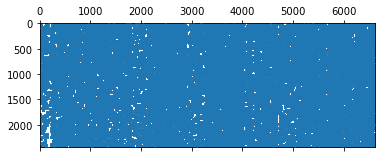

In [21]:
# Visualize the sparce coo matrix
coo_mat = coo_matrix(X).tocsr()
print(coo_mat.todense())
plt.spy(coo_mat, marker = 's', markersize = 2)
# ax = plot_coo_matrix(m)
# # convert to csr and use spy
# ax

Here is a simple word cloud to easily visualize the most common words in the dataset. The common words are very predictable given the naute of the dataset.

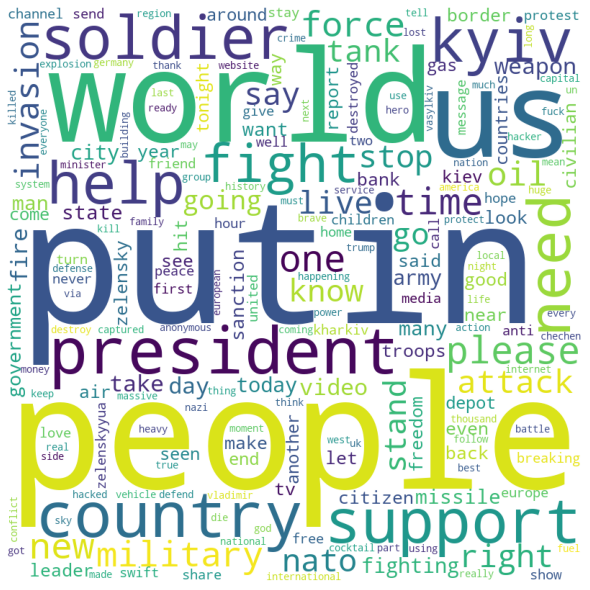

In [22]:
# Create wordcloud
comment_words = ''
for val in df['text']:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10,
                collocations = False).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

Here we decided to utilize Non-negative Matrix Factorization (NMF) in order to perform topic modeling. NMF is an unsupervised learning technique which decomposes high-dimensional vectors into a lower-dimensional representation. We first determine the number optimal number of topics in with an elbow chart. We then fit our model, and the most common topics in each topic group is presented to us.

CPU times: user 2min 3s, sys: 1.55 s, total: 2min 5s
Wall time: 21.4 s


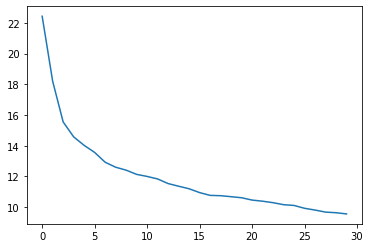

In [23]:
# NMF Component Elbow Chart
vect = CountVectorizer(stop_words='english')
vectors = vect.fit_transform(df['text']).todense() # (documents, vocab)
vectors.shape #, vectors.nnz / vectors.shape[0], row_means.shape
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

plt.plot(s[:30])

In [24]:
# do NMF
nmf = NMF(n_components=6, solver="mu")
W = nmf.fit_transform(X)
H = nmf.components_

for i, topic in enumerate(H):
     print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in words[topic.argsort()[-10:]]])))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


Topic 1: need,going,hero,zelensky,fight,world,soldier,people,president,putin
Topic 2: moment,hit,vasylkiv,explosion,kyiv,near,missile,fire,depot,oil
Topic 3: presidencygr,fuel,cocktail,blood,truck,please,tank,fuck,fighting,stop
Topic 4: around,reading,using,phone,track,gathering,geolocation,turn,help,please
Topic 5: reality,happens,anonymous,truth,happening,state,broadcast,channel,hacked,tv
Topic 6: sky,look,people,fighting,kyiv,stand,country,like,support,right


Before we perform clustering of the data, we must factor our matrix using a method called Singular Value Decomposition (SVD). SVD represents the data as a series of linear approximations that expose the underlying meaning and structure of the matrix. It also reduces the matrix so our clustering can be performed more efficiently.

In [26]:
# SVD Variance
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
mat_lsa = lsa.fit_transform(X)
print("Explained variance of the SVD: {}%".format(int(svd.explained_variance_ratio_.sum() * 100)))
print(mat_lsa)

Explained variance of the SVD: 2%
[[ 0.7684159  -0.21048524 -0.06388063  0.54229418  0.25897732]
 [ 0.36149254 -0.22645494  0.34773496  0.44816123  0.70446662]
 [ 0.93109476 -0.2011376  -0.27216313 -0.1334214   0.02705884]
 ...
 [ 0.85187943 -0.28521819 -0.39427755  0.19341587 -0.00935567]
 [ 0.8373469  -0.2642163  -0.21694995  0.41309555  0.10641754]
 [ 0.80590582 -0.34627619  0.03068781 -0.45390264  0.15375065]]


We now want to start fitting our k-means model. K-means is an unsupervised learning technique which clusters the data based on the distance to the centroids of the chosen amount of clusters. The optimal amount of clusters here are also chosen by an elbow curve.

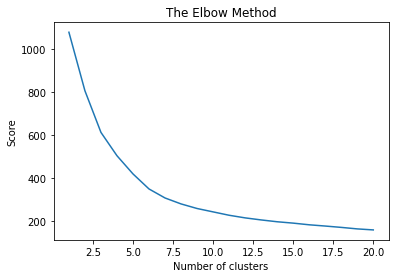

In [27]:
# K-Means Clustering Elbow Chart
k = 20
score = []
for i in range(1,k + 1):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=5,random_state=0)
    kmeans.fit(mat_lsa)
    score.append(kmeans.inertia_)
plt.plot(range(1,k + 1 ),score)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.savefig('elbow.png')
plt.show()

In [29]:
# K-Means model fitting
k = 6
model = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=600, tol=0.000001, random_state=0)
model.fit(mat_lsa)

KMeans(max_iter=600, n_clusters=6, random_state=0, tol=1e-06)

In [30]:
# Adding clusters to dataset
clusters = model.predict(mat_lsa)
df["ClusterName"] = clusters
df.head()

,username,text,retweetcount,ClusterName
4954,second_tonsuke,zelenskyyua tv address people might moving spe...,129249.0,3
3558,justsomeDD,anonymous collective officially cyber government,48882.0,2
3567,pawrevere1,learn use prepare bear arms sounds surreal day...,44737.0,5
143,TrabiMechanic,gonna listen speech let one kenya ambassador u...,43790.0,5
3447,fmsesma,300 scientists scientific journalists signed o...,39337.0,3


In [31]:
# Find center of each cluster
print ("The cluster centers are:")
cs = np.round(model.cluster_centers_, 3)
print (cs)

The cluster centers are:
[[ 0.638  0.66   0.012 -0.05   0.009]
 [ 0.808 -0.172 -0.171 -0.337  0.212]
 [ 0.491 -0.05   0.111  0.266  0.699]
 [ 0.625 -0.182  0.076  0.613 -0.187]
 [ 0.455 -0.068  0.64  -0.253 -0.214]
 [ 0.88  -0.095 -0.262  0.115 -0.12 ]]


5    856
1    521
0    495
3    307
2    161
4    105
Name: ClusterName, dtype: int64


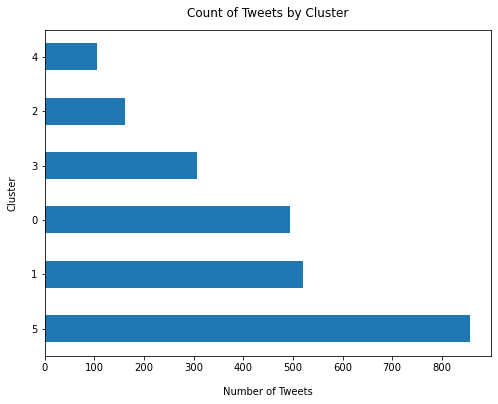

In [32]:
# Count the total number of values in each cluster
counts_per_clus = df['ClusterName'].value_counts()
print(counts_per_clus)
counts_per_clus.plot(kind='barh',figsize=(8,6))
plt.xlabel("Number of Tweets", labelpad=14)
plt.ylabel("Cluster", labelpad=14)
plt.title("Count of Tweets by Cluster", y=1.02);

The next few cells visualize the most common words in each of our clusters. This is very helpful because it shows how the clusters are different based on the words which they contain in them.

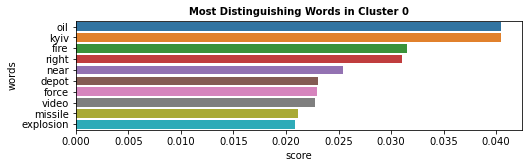

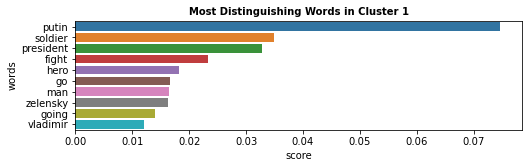

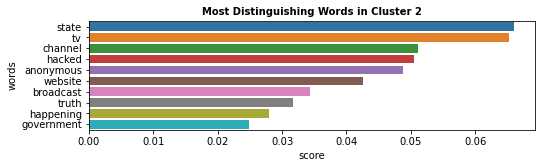

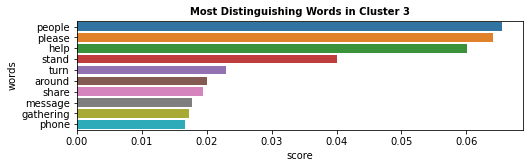

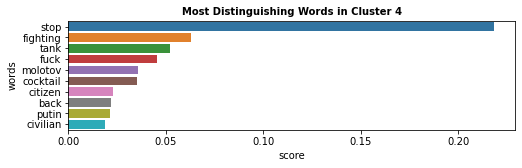

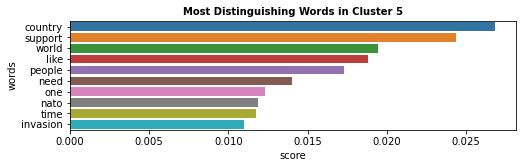

In [45]:

# Most distinguishing words by cluster

def get_dist_cluster_words(df,tf_idf_array,words,n_clusters,n_top_words):

    dfs = []

    for clus in range(n_clusters):

        ind_clus = np.where(df.ClusterName == clus)

        x_means = np.mean(tf_idf_array[ind_clus], axis = 0)

        top_ind = np.argpartition(x_means, -n_top_words)[-n_top_words:]

        top_ind_sorted = top_ind[np.argsort(x_means[top_ind])[::-1]]

        top_words = [(words[i], x_means[i]) for i in top_ind_sorted]

        clus_df = pd.DataFrame(top_words, columns = ['words','score'])

        dfs.append(clus_df)

    return dfs

 

def plotWords(dfs, n_feats):

    for i in range(0, len(dfs)):

        plt.figure(figsize=(8, 2))

        plt.title(("Most Distinguishing Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')

        sns.barplot(x = 'score' , y = 'words', orient = 'h' , data = dfs[i][:n_feats])

       

dfs = get_dist_cluster_words(df,X,words,k,10)

plotWords(dfs,10)

Here we provide some basic sentiment analysis which will classify each tweet into a category of positive, negative, or neutral. Since our data is unlabeled, this is performed though a package called VADER which compares the tweets to a data frame of commonly used words for each category, and returns the predicted category based on the highest similarity score. We then visualize the results in a histogram. We can see "Neutral" is the most classified category.

   Negative  Positive  Neutral
0     0.182     0.068    0.750
1     0.191     0.167    0.642
2     0.141     0.123    0.737
3     0.093     0.285    0.622
4     0.357     0.115    0.500
5     0.145     0.223    0.632


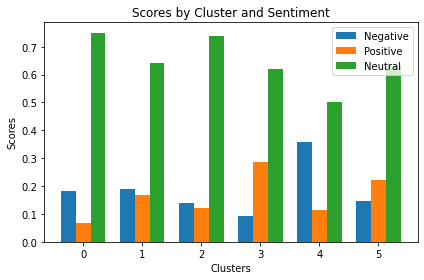

In [34]:
# Negative vs Positive vs Neutral Scoring by Cluster
def pol_clusters(df,n_clusters,clusters,neg_scores,pos_scores,neu_scores,sia):
    for i in range(n_clusters):
        clusters.append(i)
        df_clus = df[df.ClusterName == i]
        text = []
        for w in df_clus['text']:
            text.append(w)
        neg = 0
        pos = 0
        neu = 0

        for tweet in text:
            neg += sia.polarity_scores(tweet)['neg']
            pos += sia.polarity_scores(tweet)['pos']
            neu += sia.polarity_scores(tweet)['neu']
        
        neg_scores.append(round(neg/len(text),3))
        pos_scores.append(round(pos/len(text),3))
        neu_scores.append(round(neu/len(text),3))
    
    return clusters, neg_scores, pos_scores, neu_scores
    
sia = SentimentIntensityAnalyzer()
clusters, neg_scores, pos_scores, neu_scores = [],[],[],[]
clusters, neg_scores, pos_scores, neu_scores = pol_clusters(df,k,clusters,neg_scores,pos_scores,neu_scores,sia)

df_senti_scores = pd.DataFrame({'Negative':neg_scores,
                               'Positive':pos_scores,
                               'Neutral':neu_scores})
print(df_senti_scores)

loc = np.arange(len(clusters))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(loc - width, neg_scores, width, label='Negative')
rects2 = ax.bar(loc , pos_scores, width, label='Positive')
rects3 = ax.bar(loc + width, neu_scores, width, label='Neutral')

# Add some text for labels, title
ax.set_ylabel('Scores')
ax.set_title('Scores by Cluster and Sentiment')
ax.set_xlabel('Clusters')
ax.legend()

fig.tight_layout()
plt.show()

Since we felt that the classic sentiment analysis technique of classifying the data into positive, negative, or neural did not provide much insight into a dataset of this nature, We decided a different method would be more insightful. The package is called text2emotion. It is also an unsupervised classification package, but rather than compare our text to common words in the positive, negative, or neutral category, it compares our text to common words in 5 different categories: happy, angry, surpise, sad, and fear.

In [35]:
# Emotion score for each word in text
emos = []
for w in lemmatized:
    x = te.get_emotion(w)
    emos.append(x)
emotion = pd.DataFrame(emos)
emotion.head()

,Happy,Angry,Surprise,Sad,Fear
0,0.00,0.2,0.20,0.00,0.60
1,0.00,0.0,0.00,0.00,0.00
2,0.33,0.0,0.17,0.33,0.17
3,0.00,0.0,0.00,0.50,0.50
4,0.00,0.0,0.00,0.50,0.50


In [36]:
# Emotion scores by word by cluster
clusters = []
for i in range(k):
    clusters.append(pd.DataFrame(df['text'].loc[df['ClusterName'] == i]))
    
EC = []
for i in range(k):
    EC.append([te.get_emotion(s) for s in clusters[i]['text']])

In [37]:
# Emotion score dataframe
cluster_emo_dfs = []
for i in range(k):
    cluster_emo_dfs.append(pd.DataFrame(EC[i]))

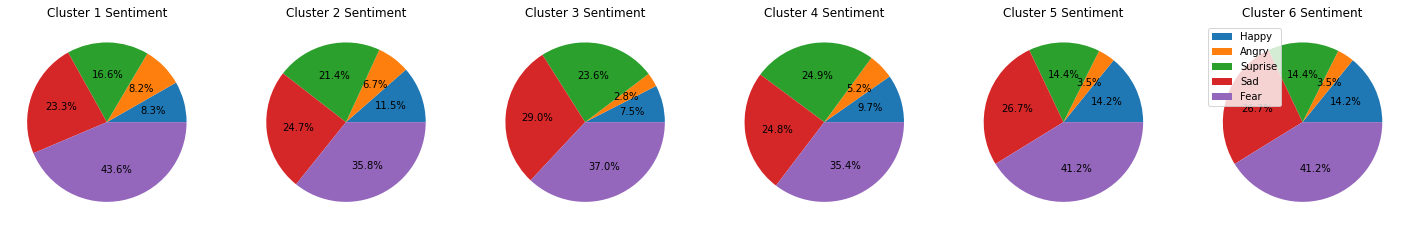

In [44]:
# Emotion Score Pie Chart by Cluster
x1 = cluster_emo_dfs[0][cluster_emo_dfs[0].columns[0:]].sum()
x2 = cluster_emo_dfs[1][cluster_emo_dfs[1].columns[0:]].sum()
x3 = cluster_emo_dfs[2][cluster_emo_dfs[2].columns[0:]].sum()
x4 = cluster_emo_dfs[3][cluster_emo_dfs[3].columns[0:]].sum()
x5 = cluster_emo_dfs[4][cluster_emo_dfs[4].columns[0:]].sum()
x6 = cluster_emo_dfs[5][cluster_emo_dfs[5].columns[0:]].sum()

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)
ax1.pie(x1,autopct='%1.1f%%')
ax1.set_title("Cluster 1 Sentiment")
ax2.pie(x2,autopct='%1.1f%%')
ax2.set_title("Cluster 2 Sentiment")
ax3.pie(x3,autopct='%1.1f%%')
ax3.set_title("Cluster 3 Sentiment")
ax4.pie(x4,autopct='%1.1f%%')
ax4.set_title("Cluster 4 Sentiment")
ax5.pie(x5,autopct='%1.1f%%')
ax5.set_title("Cluster 5 Sentiment")
ax6.pie(x5,autopct='%1.1f%%')
ax6.set_title("Cluster 6 Sentiment")
fig.set_size_inches(25,25)
labels = ['Happy', 'Angry', 'Suprise', 'Sad', 'Fear',]
plt.legend(labels, loc = 'upper left')
plt.show()

What we have accomplished:
In this project we were able to take a sparse dataset of tweets pertaining to the war in Ukraine and perform clustering and sentiment analysis on those tweets. We used matrix reduction methods such as NMF and SVD to better process the data, and we used k-means clustering and sentiment analysis to gain insight on the data.

As we can see, fear is the most common emotion in every cluster, and angry is the least.

Conclusion:
From all our various clustering/word-highlight methods (NMF topics, K-Means cluster distinguishing words, and the word cloud), it’s clear that most of the groups and topics of the data are of similar nature. Most people feel the same emotions towards the current war in Ukraine: fear and sadness.